<a href="https://colab.research.google.com/github/pinnero/pinnero/blob/main/fresco_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision.models as models
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

# Update the paths to your data in Google Drive
drive_root = '/content/drive/MyDrive'  # Root directory of your Google Drive
data_path = f"{drive_root}/labeled_images"  # Update this path

# Load dataset and apply transformations
dataset = ImageFolder(root=data_path, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
# Define your custom CNN architecture with ResNet transfer learning

class CustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(CustomCNN, self).__init__()
        # Load a pre-trained ResNet model (ResNet18 in this case)
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all layers of ResNet to avoid training them
        for param in self.resnet.parameters():
            param.requires_grad = False

       # Replace the last fully connected layer of ResNet
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)  # Change this line




    def forward(self, x):
        x = self.resnet(x)
        return x

# Initialize the custom CNN model
model = CustomCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/15] | Validation Loss: 1.5311 | Accuracy: 23.73%
Epoch [2/15] | Validation Loss: 1.4072 | Accuracy: 28.81%
Epoch [3/15] | Validation Loss: 1.2866 | Accuracy: 40.68%
Epoch [4/15] | Validation Loss: 1.1245 | Accuracy: 55.93%
Epoch [5/15] | Validation Loss: 1.1716 | Accuracy: 49.15%
Epoch [6/15] | Validation Loss: 1.0922 | Accuracy: 52.54%
Epoch [7/15] | Validation Loss: 1.1406 | Accuracy: 49.15%
Epoch [8/15] | Validation Loss: 1.0551 | Accuracy: 57.63%
Epoch [9/15] | Validation Loss: 0.9801 | Accuracy: 59.32%
Epoch [10/15] | Validation Loss: 0.9722 | Accuracy: 57.63%
Epoch [11/15] | Validation Loss: 0.9731 | Accuracy: 57.63%
Epoch [12/15] | Validation Loss: 0.9258 | Accuracy: 62.71%
Epoch [13/15] | Validation Loss: 0.8259 | Accuracy: 71.19%
Epoch [14/15] | Validation Loss: 0.8861 | Accuracy: 67.80%
Epoch [15/15] | Validation Loss: 0.9632 | Accuracy: 59.32%
Style 0: Accuracy = 51.11%
Style 1: Accuracy = 44.67%
Style 2: Accuracy = 57.22%
Style 3: Accuracy = 68.89%


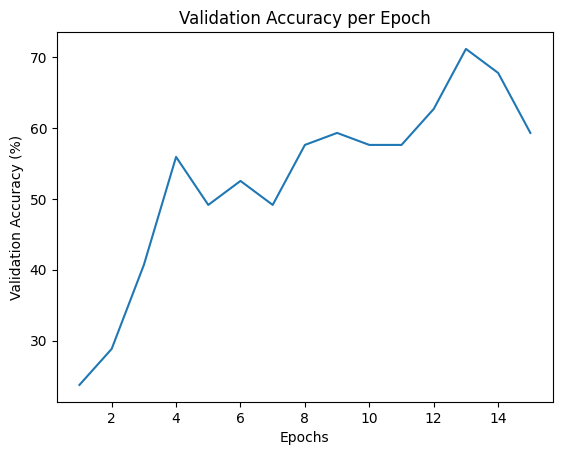

In [25]:

import matplotlib.pyplot as plt

# Lists to store accuracy values per epoch
val_accuracy_history = []
style_correct = {0: 0, 1: 0, 2: 0, 3: 0}
style_total = {0: 0, 1: 0, 2: 0, 3: 0}
# Training loop
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation after each epoch
    model.eval()
    val_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass and compute loss
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()

            # Count correct predictions
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Count mistakes per style
            for i in range(len(labels)):
                style_total[labels[i].item()] += 1
                if predicted[i] == labels[i]:
                    style_correct[labels[i].item()] += 1


    val_loss /= len(val_loader)
    accuracy = 100.0 * correct / len(val_dataset)

    # Append validation accuracy to history
    val_accuracy_history.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Validation Loss: {val_loss:.4f} | Accuracy: {accuracy:.2f}%")

# Print accuracy per style
for style in range(4):
    style_acc = 100.0 * style_correct[style] / style_total[style]
    print(f"Style {style}: Accuracy = {style_acc:.2f}%")

# Plot the validation accuracy trends
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, val_accuracy_history)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy per Epoch")
plt.show()
